In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sc
from altair import *
import matplotlib.pyplot as plt
from collections import OrderedDict
from ipywidgets import interact, interactive, fixed
from IPython.display import display
from sklearn.linear_model import Ridge
from feat import *

In [2]:
cldir = './data/CL/'
rutdir = './data/RUT/'
gldir = './data/GLD/'
src = cldir
labelName = 'Z_dailydir'
pricestats=['Date', 'Z_dailypct']
data = pd.read_csv(src + '/1_merged/in_sampleFF.csv')
data['year'] = data['Date'].str[:4].astype(int)
print(data.head())

         Date  N_buzz  N_conflict  N_consumptionVolume  N_emotionVsFact  \
0  2000-01-01   201.1    0.004973             0.004973         0.129164   
1  2000-01-02   132.7    0.000000             0.004973         0.141485   
2  2000-01-03   381.2   -0.028856             0.004973         0.098898   
3  2000-01-04  1078.8   -0.054690            -0.001854         0.129357   
4  2000-01-05  1363.6   -0.020534            -0.002933         0.146836   

     N_fear   N_gloom     N_joy  N_longShort  N_longShortForecast  ...   \
0  0.002486  0.024863       NaN          NaN                  NaN  ...    
1  0.007536  0.033911  0.030143          NaN                  NaN  ...    
2  0.007536  0.019675  0.030143     0.000000                  NaN  ...    
3  0.012050  0.021320  0.030143    -0.012977                  NaN  ...    
4  0.015400  0.042901  0.000733     0.003300                  NaN  ...    

      X_Open  X_Prev. Day Open Interest   X_Settle  X_Volume  X_dailydir  \
0        NaN          

In [3]:
def correlationMatrix(data, features, labels):
    if (not features or not labels):
        #Full correlation matrix
        corr = data.corr()
    else:
        corr = pd.DataFrame()
        for feat in features:
            row = {}
            row['feature'] = feat
            row.update({label: data[feat].corr(data[label]) for label in labels})
            corr = corr.append(row, ignore_index=True)
    return corr

In [4]:
toGraph = data[['Date', 'N_relativeBuzz', 'N_stress','Z_dailypct', 'Z_dailydir']].copy()
toGraph['daymonth'] = toGraph['Date'].apply(lambda x: '0000' + x[4:])
toGraph['year'] = toGraph['Date'].str[:4]

In [5]:
# Chart(toGraph, config=Config(numberFormat=".3n")).mark_bar().encode(
#     x=X('daymonth:T', timeUnit='monthdate'),
#     y=Y('N_stress'),
#     color='Z_dailydir',
#     row='year'
# )

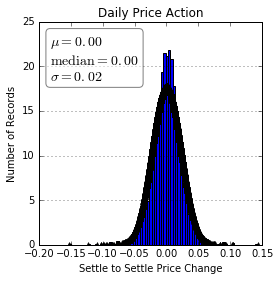

In [6]:
def plot_dist(series):
    dailypct = series.dropna().sort_values(inplace=False)
    mean = np.mean(dailypct)
    median = np.median(dailypct)
    sdev = np.std(dailypct)
    fit = sc.stats.norm.pdf(dailypct, mean, sdev)

    plt.figure(figsize=(4,4))
    plt.title('Daily Price Action')
    plt.xlabel('Settle to Settle Price Change')
    plt.ylabel('Number of Records')
    plt.grid(b=True, which='major', axis='y')
    textstr = '$\mu=%.2f$\n$\mathrm{median}=%.2f$\n$\sigma=%.2f$'%(mean, median, sdev)

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    plt.axes().text(0.05, 0.95, textstr, transform=plt.axes().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    plt.hist(dailypct, bins=80, normed=True)
    plt.plot(dailypct, fit,'k^');
    
plot_dist(data['Z_dailypct'])

In [7]:
unholed = data['Z_dailypct'].dropna().sort_values(inplace=False)
mod = sc.stats.norm(np.mean(unholed), np.std(unholed))

def dist_probs(value, showboth=True):
    inner = mod.cdf(value) - mod.cdf(-value)
    print('probability range from', str(value), 'to', str(-value))
    print('inner probability:', inner)
    print('outer probability:', 1-inner)
    if (showboth):
        print('probability less than', str(-value), ':', mod.cdf(-value))
        print('probability greater than', str(value), ':', 1-mod.cdf(value))

stat, pvalue = sc.stats.normaltest(unholed, nan_policy='omit')
print('\ntest stat:', stat)
print('pvalue:', pvalue)
print('small pvalue => normal distribution')
interact(dist_probs, value=(0.01, .1, .001), showboth=False)

probability range from 0.055 to -0.055
inner probability: 0.985502292577
outer probability: 0.0144977074232


<function __main__.dist_probs>

In [8]:
#Show sentiment characteristics at sizable (at least greater than 1%) moves
move_thresh = .01
large_moves_pos = data[data.Z_dailypct >= move_thresh]
large_moves_neg = data[data.Z_dailypct <= -move_thresh]
print('all rows:', len(data))
print('all rows, no weekends:', len(data.dropna(axis=0, subset=['Z_dailydir'])))

print('\ntotal large moves:', len(large_moves_pos) + len(large_moves_neg))
print('large up moves [greater than', str(move_thresh) +']:', len(large_moves_pos))
print('large down moves [less than', str(-move_thresh) +']:', len(large_moves_neg))

all rows: 5844
all rows, no weekends: 4014

total large moves: 2340
large up moves [greater than 0.01]: 1185
large down moves [less than -0.01]: 1155


Create interactive visualization
    selection of sentiment/feature, selection of simple transform, selection of delta transform, coloring variable (label),
    lower/upper pctchange bounds and whether positive/negative/both included in graph
    remove Nans, remove zeros
    checkboxes for years included
    a useful animation if relevant

QUESTION:
    X axis may be irrlevant - better to collapse all graphs to 1 dimension so that all sentiments can be viewed simultaneously!
    Alternate - keep x axis as time, not having extra dimension may crowd the graph
    Better - Give option to do this

    TODO:
        -relabel data into more than just up/down -> bin label based on histogram of price data
        -run a massive computation script that runs multiple models with different types of transforms and dumps the resultss

In [9]:
def plot_feature(feature=None, label=None,
                remove_nans=True, remove_zeros=True,                                           #pre-processing options
                atomic_transform=lambda x:x, delta_transform=lambda x:x, combo='delta_atomic', #processing options
                low_clip=-1.0, high_clip=1.0,
                show_class='all'):                                                             #post-processing options

    assert(feature and label)
    #TODO - option for gradient coloring
    colors = {1: "blue", 0: "white", -1: "red", -2: "black"}
    output = pd.DataFrame({feature: data[feature], label: data[label], 'year': data['year']})

    #Drop rows with no label
    output.dropna(axis=0, subset=[label], inplace=True)

    #Pre processing
    output[feature].fillna(value=-2, axis=0, inplace=True,)
    if (remove_nans):
        output = output[output[feature] != -2]
    if (remove_zeros):
        output = output[output[feature] != 0]
        
    #TODO - upper and lower bound filtering (throw out middle)
        #past_period - number of rows behind the "big moves" to keep in
        #Need this for delta transforms
    
    if (combo == 'atomic'):
        output[combo] = atomic_transform(output[feature])
    elif (combo == 'delta'):
        output[combo] = delta_transform(output[feature])
    elif (combo == 'atomic_delta'):
        output[combo] = atomic_transform(delta_transform(output[feature]))
    elif (combo == 'delta_atomic'):
        output[combo] = delta_transform(atomic_transform(output[feature]))
    else:
        output[combo] = output[feature]
    low_clip = low_clip if low_clip > output[combo].min() else output[combo].min()
    high_clip = high_clip if high_clip < output[combo].max() else output[combo].max()
    output[combo] = np.clip(output[combo], low_clip, high_clip)

    #Post processing
    if (show_class != 'all'):
        if (show_class == 'up'):
            output = output[output[label] == 1]
        elif (show_class == 'down'):
            output = output[output[label] == -1]
        elif (show_class == 'sideways'):
            output = output[output[label] == 0]
    
    #TODO - add year specific removal option

    data_space = np.linspace(0, len(output[combo])-1, num=len(output[combo]))
    plt.figure(figsize=(25,10))
    #plt.figure().tight_layout()
    plt.title('Data Segmentation Graph')
    plt.xlabel('Observation')
    plt.ylabel('Feature Value')
    plt.xlim([-100, 4100])
    plt.grid(b=True, which='major', axis='y')
    #textstr = '$\mu=%.2f$\n$\mathrm{median}=%.2f$\n$\sigma=%.2f$'%(mean, median, sdev)
    plt.scatter(data_space, output[combo], c=[colors[x] for x in output[label]]);
    return

In [10]:
#config options
atomic_fn_options = OrderedDict({'nothing': lambda x:x, 'round': lambda a: np.around(a, 2), 'ln':np.log, 'log10':np.log10, 'sine':np.sin, 'sinh':np.sinh})
delta_fn_options = OrderedDict({'nothing': lambda x:x, 'ln':np.log, 'log10':np.log10, 'sine':np.sin, 'sinh':np.sinh})
feature_list = tuple(sorted([col for col in data.columns if ((col[0]=='N' or col[0]=='S') and 'buzz' not in col)]))

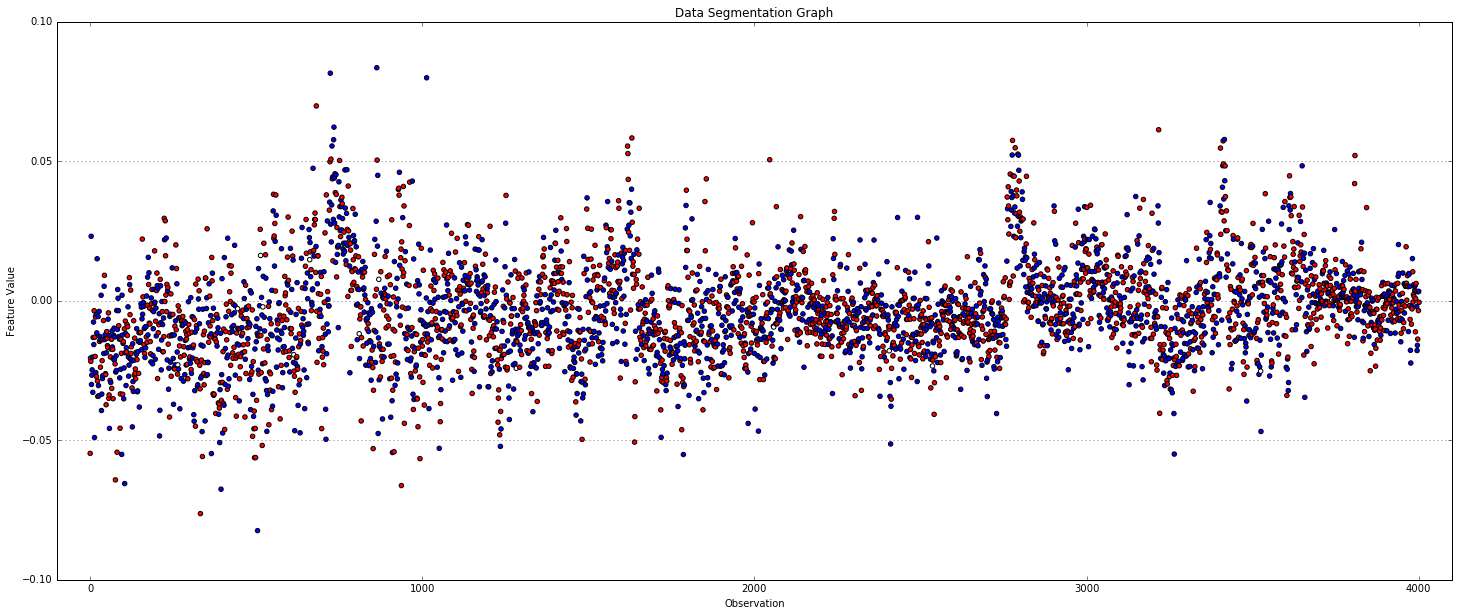

In [11]:
interact(plot_feature,
                feature=feature_list,
                label=('Z_dailydir', 'Z_dailypct'),
                remove_nans=OrderedDict({'remove': True, 'keep': False}),
                remove_zeros=OrderedDict({'remove': True, 'keep': False}),
                atomic_transform=atomic_fn_options,
                delta_transform=delta_fn_options,
                combo=('none','atomic','delta','atomic_delta','delta_atomic'),
                low_clip=(-1.0, 0.0, .001),
                high_clip=(.0, 1.0, .001),
                show_class=('all', 'up', 'down', 'sideways'));

In [12]:
def labelledStats(data, removeNAs, removeZeros, outputFile):
    try:
        data = data.set_index('Date')
    except:
        pass
    pdf = PdfPages(outputFile)
    colors = {1: "blue", 0: "white", -1: "red", -2: "black"}

    for col in data:
        if (col[0] != 'Z'):
            pyplot.title(col)
            feature = data[col]
            label = data['Z_dailydir'].fillna(-2)
            if (removeNAs):
                noNa = pd.DataFrame({'feature': feature, 'label': label})
                noNa = noNa[noNa.label != -2]   #remove all rows with missing value
                feature = noNa['feature']
                label = noNa['label']
            if (removeZeros):
                noZero = pd.DataFrame({'feature': feature, 'label': label})
                noZero = noZero[noZero.feature != 0] #remove all rows with '0' value
                feature = noZero['feature']
                label = noZero['label']
            dataSpace = np.linspace(0, len(feature)-1, num=len(feature))
            pyplot.scatter(dataSpace, feature, c=[colors[x] for x in label])
            #pyplot.ylim(-1, 1)         
            #pyplot.legend(loc='upper right')
            pdf.savefig()
            pyplot.cla()
    pdf.close()
    return

In [13]:
def infoPurityGraphs(filedir, files):
    numBins = 500
    for datasource in files:
        df = tn.load_csv(Process.g_tsetdir +filedir, datasource +'.csv')
        df.drop('Unnamed: 0', axis=1, inplace=True)     #Get rid of id col
        df.drop('date', axis=1, inplace=True)           #Get rid of date col
        pdf = PdfPages(Process.g_reportdir + 'purityhists/' +filedir +datasource +'.pdf')

        #Split into up, down, and sideways groups
        ups = df.loc[df['label'] == 1]
        downs = df.loc[df['label'] == -1]
        sideways = df.loc[df['label'] == 0]        

        for column in df:
            if (column != 'label'):
                pyplot.title(column)
                pyplot.hist(ups[column].values, bins=numBins, alpha=0.3, label='up')
                pyplot.hist(downs[column].values, bins=numBins, alpha=0.3, label='down')
                pyplot.hist(sideways[column].values, bins=numBins, alpha=0.3, label='sideways')
                pyplot.legend(loc='upper right')
                pdf.savefig()
                pyplot.cla()
        pdf.close()

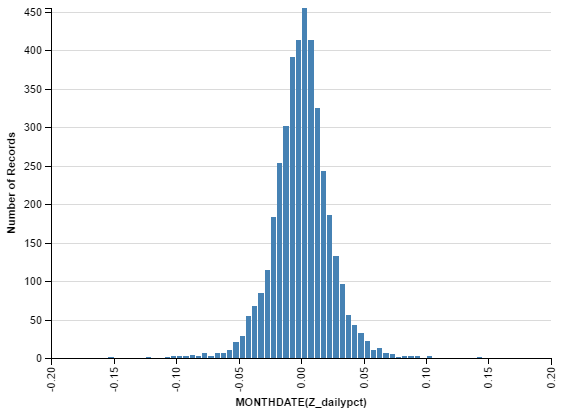

In [14]:
Chart(toGraph, config=Config(numberFormat=".3n")).mark_bar().encode(
    x=X('Z_dailypct', timeUnit='monthdate', bin=Bin(maxbins=80)),
    y=Y('count(*)')
)

In [15]:
# Chart(toGraph, config=Config(numberFormat=".3n")).mark_bar().encode(
#     x=X('Z_dailypct', timeUnit='monthdate', bin=Bin(maxbins=80)),
#     y=Y('count(*)'),
#     row='year'
# )